In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
%matplotlib inline

In [3]:
def abr(t, pop):
    la, lb, lr, ra, rb, rr = pop
    ka, da, dab = 400, 2, 400
    kb, kbb, db, dba = 2, 30, 2.8, 30
    kr, krb, dr = 0.1, 1.5, 0.2

    dladt = ka*(1-la-ra)*lr - da*la - dab*la*lb**2
    dlbdt = (1-lb-rb)*(kb + kbb*lb) - db*lb - dba*la*lb**2
    dlrdt = (1-lr-rr)*(kr+krb*lb) - dr*lr
    dradt = ka*(1-la-ra)*rr - da*ra - dab*ra*rb**2
    drbdt = (1-lb-rb)*(kb + kbb*rb) - db*rb - dba*ra*rb**2
    drrdt = (1-lr-rr)*(kr+krb*rb) - dr*rr
    dpop = np.array([dladt, dlbdt, dlrdt, dradt, drbdt, drrdt])
    return dpop

In [10]:
np.linspace(0.01, 60, num=6000)

array([1.000e-02, 2.000e-02, 3.000e-02, ..., 5.998e+01, 5.999e+01,
       6.000e+01])

In [11]:
tspan = np.linspace(0.01, 60, num=6000)
pop0 = [1, 0, 0, 0, 1, 1]
sol = integrate.solve_ivp(abr, [tspan[0], tspan[-1]], pop0, method='RK45', t_eval=tspan)
dpop = abr(sol.t, sol.y)

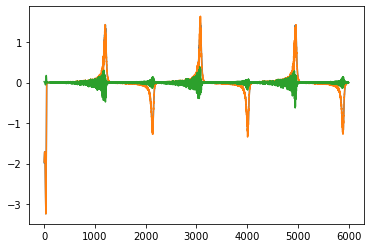

In [12]:
plt.plot(np.diff(sol.y, axis=1)[0]/0.01)
plt.plot(dpop[0][1:])
plt.plot(dpop[0][1:] - np.diff(sol.y, axis=1)[0]/0.01)

In [4]:
def random_sampling(data, porpotion):
    sampled_data = np.empty(data.shape)
    sampled_data[:] = np.nan
    n = data.shape[1]
    for i in range(data.shape[0]):
        sample_idx = random.sample(range(n), int(n*porpotion))
        sampled_data[i][sample_idx] = data[i][sample_idx]
    return sampled_data

sample_pop = random_sampling(sol.y, 0.3)

In [209]:
# interpolation
# from scipy.interpolate import interp1d
# interp_pop = []
# for i in range(sample_pop.shape[0]):
#     t_idx = np.argwhere(~np.isnan(sample_pop[i])).T[0]
#     sampled_t = sol.t[t_idx]
#     sampled_data = sample_pop[i][t_idx]
#     y_interp = np.interp(tspan,sampled_t,sampled_data)
#     interp_pop.append(y_interp)


In [5]:
def funkSVD(rating_mat, latent_features, learning_rate, iters):
    n_s, n_t = rating_mat.shape[0], rating_mat.shape[1]
    s_matrix, t_matrix = np.random.rand(n_s, latent_features), np.random.rand(latent_features, n_t)
    # s_matrix, t_matrix = 0.5*np.ones((n_s, latent_features)), 0.5*np.ones((latent_features, n_t))
    sse_initial = 0
    for p in range(iters):
        old_see = sse_initial
        sse_initial = 0 

        for i in range(n_s):
            for j in range(n_t):
                if not math.isnan(rating_mat[i][j]):
                    diff = rating_mat[i][j] - s_matrix[i,:].dot(t_matrix[:,j])
                    sse_initial  += diff**2

                    for k in range(latent_features):
                        s_matrix[i][k] += learning_rate*(2*diff*t_matrix[k][j])
                        t_matrix[k][j] += learning_rate*(2*diff*s_matrix[i][k])

    est_mat = s_matrix.dot(t_matrix)
    return est_mat


In [6]:
from scipy.linalg import qr
def randomSVD(X, r, q, p):
    ny = X.shape[1]
    p = np.random.rand(ny, r+p)
    z = X.dot(p)
    for k in range(q):
        z = X.dot(X.T.dot(z))
    Q, R = qr(z, mode='economic')
    Y = Q.T.dot(X)
    UY, S, V = np.linalg.svd(Y)
    U = Q.dot(UY)
    return U, S, V[:6,:]


In [7]:
est_mat = funkSVD(np.array(sample_pop), 10, 0.005, 2000)

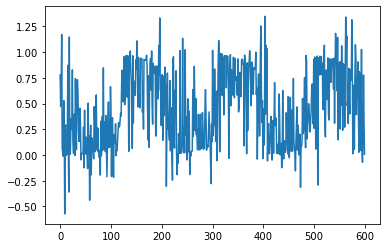

In [240]:
plt.plot(est_mat[0])

In [ ]:
plt.plot(np.diff(est_mat)[0])
plt.plot(np.diff(est_mat)[0])

In [249]:
def ft_data(pop, tspan, dt):
    n = len(tspan)
    y_ft = []
    for i in range(pop.shape[0]):
        fhat = np.fft.fft(est_mat[i], n)
        PSD = fhat*np.conj(fhat)/n
        freq = (1/(dt*n))*np.arange(n)

        L = np.arange(1, np.floor(n/2), dtype= 'int')

        indices = PSD > 5
        PSDclean  = PSD * indices
        fhat = indices*fhat
        ffilt = np.fft.ifft(fhat)
        y_ft.append(ffilt)
    return np.array(y_ft)
    
ft_pop = ft_data(est_mat, tspan, 0.1)

In [258]:
def funkSVD_ft(ft_matrix, rating_mat, latent_features, learning_rate, iters):
    u,s,v = np.linalg.svd(ft_pop, full_matrices=False)
    n_s, n_t = rating_mat.shape[0], rating_mat.shape[1]
    s_matrix, t_matrix = u, v
    # s_matrix, t_matrix = 0.5*np.ones((n_s, latent_features)), 0.5*np.ones((latent_features, n_t))
    sse_initial = 0
    for p in range(iters):
        old_see = sse_initial
        sse_initial = 0 

        for i in range(n_s):
            for j in range(n_t):
                if not math.isnan(rating_mat[i][j]):
                    diff = rating_mat[i][j] - s_matrix[i,:].dot(t_matrix[:,j])
                    sse_initial  += diff**2

                    for k in range(latent_features):
                        s_matrix[i][k] += learning_rate*(2*diff*t_matrix[k][j])
                        t_matrix[k][j] += learning_rate*(2*diff*s_matrix[i][k])

    est_mat = s_matrix.dot(t_matrix)
    return est_mat

ft_est_mat = funkSVD_ft(ft_pop, sample_pop, 6, 0.005, 4000)

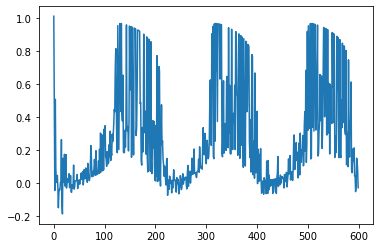

In [259]:
plt.plot(ft_est_mat[0])

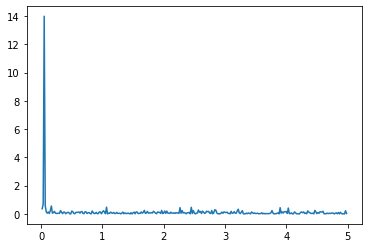

In [241]:
dt = 0.1
n = len(tspan)
fhat = np.fft.fft(est_mat[0],n)
PSD = fhat*np.conj(fhat)/n
freq = (1/(dt*n)) *np.arange(n)
# print(freq)
L = np.arange(1, np.floor(n/2), dtype ='int')

plt.plot(freq[L], PSD[L])

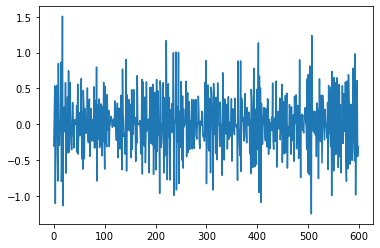

In [356]:
plt.plot(np.diff(est_mat[0]))

In [284]:
dpop_ft = abr(sol.t, ft_est_mat)


In [242]:
np.where(PSD[L]==max(PSD[L]))
freq[L][2]

0.05

In [246]:
indices = PSD > 10
PSDclean  = PSD * indices
fhat = indices*fhat
ffilt = np.fft.ifft(fhat)

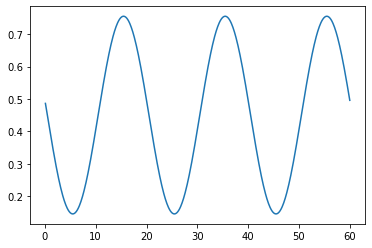

In [247]:
plt.plot(tspan, ffilt)

# u, s, v = np.linalg.svd(ffilt)

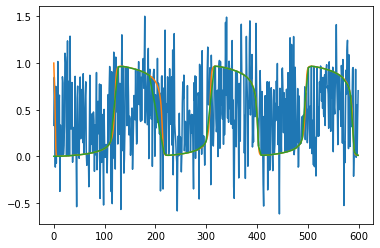

In [202]:
u,s,v = randomSVD(np.array(est_mat), 20, 1, 5)
est_mat2 = u.dot(np.diag(s)).dot(v)
plt.plot(est_mat2[0])
plt.plot(sol.y[0])
plt.plot(interp_pop[0])

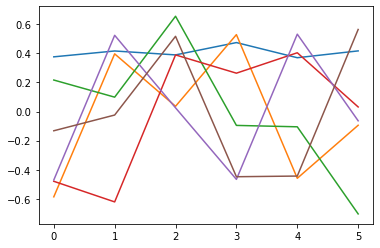

In [180]:
plt.plot(est_mat2[0])
#plt.plot(interp_pop[0])

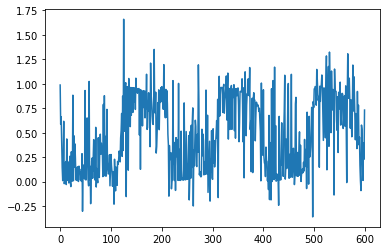

In [111]:
est_mat_u, est_mat_s, est_mat_v =  np.linalg.svd(est_mat, full_matrices=False)
est_mat_svd = est_mat_u.dot(np.diag(est_mat_s)).dot(est_mat_v)
plt.plot(est_mat_svd[:,0])

In [ ]:
plt.plot(est_mat[:,0])

In [88]:
est_mat2 = funkSVD(sample_pop, 20, 0.005, 1000)

In [110]:
est_mat2_u, est_mat2_s, est_mat2_v =  np.linalg.svd(est_mat2, full_matrices=False)

est_mat2_svd = est_mat2_u[:,:2].dot(np.diag(est_mat2_s)[:2, :2]).dot(est_mat2_v[:2,:])

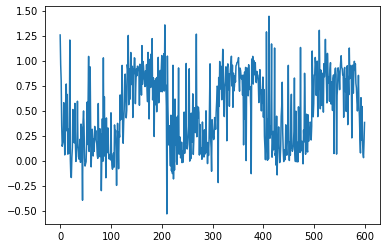

In [109]:
plt.plot(est_mat2_svd[0])

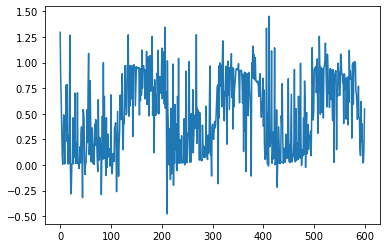

In [92]:
plt.plot(est_mat2[0])

In [16]:
def power_(d,order):
# d is the number of variables; order of polynomials
    powers = []
    for p in range(1,order+1):
        size = d + p - 1
        for indices in itertools.combinations(range(size), d-1):   ##combinations
            starts = [0] + [index+1 for index in indices]
            stops = indices + (size,)
            powers.append(tuple(map(operator.sub, stops, starts)))
    return powers
def lib_terms(data,order,description):
    #description is a list of name of variables, like [R, M, S]
    #description of lib
    descr = []
    #data is the input data, like R,M,S; order is the total order of polynomials

    d,t = data.shape # d is the number of variables; t is the number of time points
    theta = np.ones((t,1), dtype=np.float64) # the first column of lib is '1'
    P = power_(d,order)
    for i in range(len(P)):
        new_col = np.zeros((t,1),dtype=np.float64)
        for j in range(t):
            new_col[j] = np.prod(np.power(list(data[:,j]),list(P[i])))
        theta = np.hstack([theta, new_col.reshape(t,1)])
        descr.append("{0} {1}".format(str(P[i]), str(description)))
    descr = ['1']+descr

    return theta, descr

In [52]:
def sparsifyDynamics(Theta, dx, Lambda):
    m,n = dx.shape  #(248*3)
    Xi = np.dot(np.linalg.pinv(Theta), dx)  #Xi.shape = 10*3
    n = dx.shape[1]
    for k in range(100):      ###??
        small_idx = (abs(Xi) < Lambda)
        for ind in range(n):
            big_idx = (abs(Xi) >= Lambda)[:,ind]
            Xi[big_idx, ind] = np.dot(np.linalg.pinv(Theta[:,big_idx]), dx[:,ind])
    return Xi

def sparseGalerkin(t, pop, Xi, polyorder):
    theta, descr = lib_terms(np.array([pop]).T,3,[])
    dpop = theta.dot(Xi)
    return dpop[0]

In [304]:
# plt.plot(dpop_ft[0])
np.diff(ft_est_mat, axis = 1).shape

(6, 599)

In [351]:
ft_x= ft_data(x, tspan[1:], 0.1)
ft_diif_x = funkSVD_ft(ft_x, x, 6, 0.005, 4000)


In [357]:
ft_diif_x.shape

(6, 600)

(6, 599)

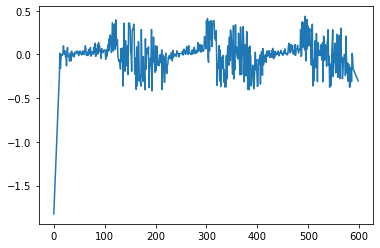

In [347]:
from scipy.signal import savgol_filter


smoothed_1dg = savgol_filter(x, window_length = 21, polyorder = 1)
plt.plot(smoothed_1dg[0])
smoothed_1dg.shape


In [53]:
dpop_diff = np.diff(sol.y,axis=1)/0.01
theta, descr = lib_terms(sol.y,3,[])
Xi = sparsifyDynamics(theta[1:,:], dpop_diff.T, 0.1)

In [69]:
tspan2 = np.linspace(0.001, 60, 60000)

In [70]:
tspan2

array([1.0000e-03, 2.0000e-03, 3.0000e-03, ..., 5.9998e+01, 5.9999e+01,
       6.0000e+01])

In [107]:
for i in range(sol.y.shape[1]):
    y_interp0 = np.interp(tspan2,tspan,sol.y[0])
    

ValueError: object too deep for desired array

In [98]:
dy_interp = (y_interp[1:] - y_interp[:-1])/0.002
dy_interp.shape

(59999,)

In [46]:
sol2 = integrate.solve_ivp(sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', args=(Xi,3))

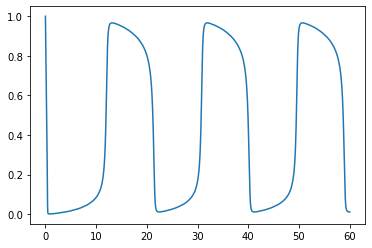

In [47]:
plt.plot(sol2.t, sol2.y[0])

In [55]:
plt.plot(sol3.t, sol3.y[0])

NameError: name 'sol3' is not defined

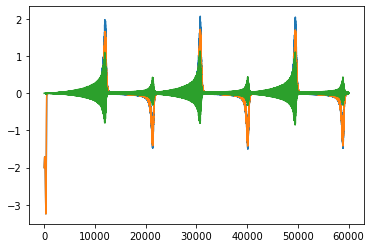

In [89]:
plt.plot(dpop_diff[0])
plt.plot(dpop[0])
plt.plot(dpop_diff[0] - dpop[0][1:])

In [126]:
dpop_diff = np.diff(sol.y, axis=1)/0.00001

In [77]:
theta, descr = lib_terms(sol.y[:,1:],3,[])
Xi = sparsifyDynamics(theta, dpop_diff.T, 0.05)

In [106]:
Xi

array([[-6.75603873e+05, -6.26781505e+03,  1.25785928e+00,
        -1.19517168e+06, -2.07301625e+04,  4.91494907e+00],
       [ 3.50589937e+06,  4.06192745e+04, -1.44660479e+01,
         5.07077731e+06,  8.49608301e+04, -2.04251443e+01],
       [-1.54669673e+06, -1.99650005e+04,  1.11252774e+01,
        -2.08342074e+06, -3.85805794e+04,  1.01175624e+01],
       [-8.57954599e+05, -1.36177493e+04,  6.43326607e+00,
        -5.23147605e+05, -2.87659566e+03,  1.93004165e+00],
       [ 3.85331460e+06,  4.47104245e+04, -1.67130850e+01,
         5.62204345e+06,  9.57882055e+04, -2.38299210e+01],
       [ 4.24364562e+04, -3.17453222e+02,  2.76221224e+00,
        -7.06265813e+04, -5.83512959e+03,  4.56833198e-01],
       [ 1.53889967e+05, -9.63994968e+02, -1.86281811e-01,
         7.56805569e+05,  1.82130703e+04, -3.59147599e+00],
       [-5.08492052e+06, -6.48089755e+04,  2.66602270e+01,
        -6.56221476e+06, -1.07850252e+05,  2.57405185e+01],
       [ 3.17031077e+06,  4.15594502e+04, -2.366

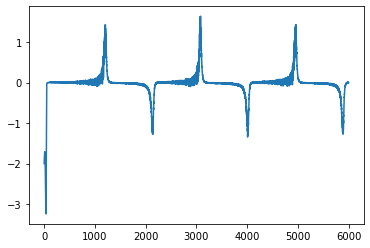

In [70]:
plt.plot(dpop[0])
plt.plot(dpop_diff[0]) 

In [68]:
sol3 = integrate.solve_ivp(sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', args=(Xi,3))

In [47]:
# t_len = sol.y.shape[1]
# time_corr = np.ones((t_len, t_len)) *-1
# i1, i2 = np.triu_indices(t_len,2), np.tril_indices(t_len,-2)
# time_corr[i1], time_corr[i2] = 0, 0
# np.fill_diagonal(time_corr, 2)

In [42]:
est_mat2 = est_mat.dot(time_corr)

In [66]:
np.nansum(2)

2

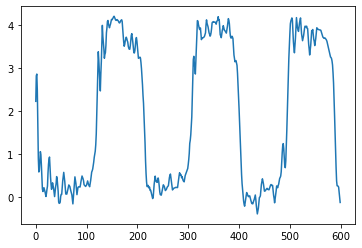

In [43]:
plt.plot(est_mat2[0])